Using this tutorial: https://huggingface.co/blog/clipseg-zero-shot

In [ ]:
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

In [1]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

Unused or unrecognized kwargs: padding.


(768, 1024)
(768, 1024)
(768, 1024)
(768, 1024)


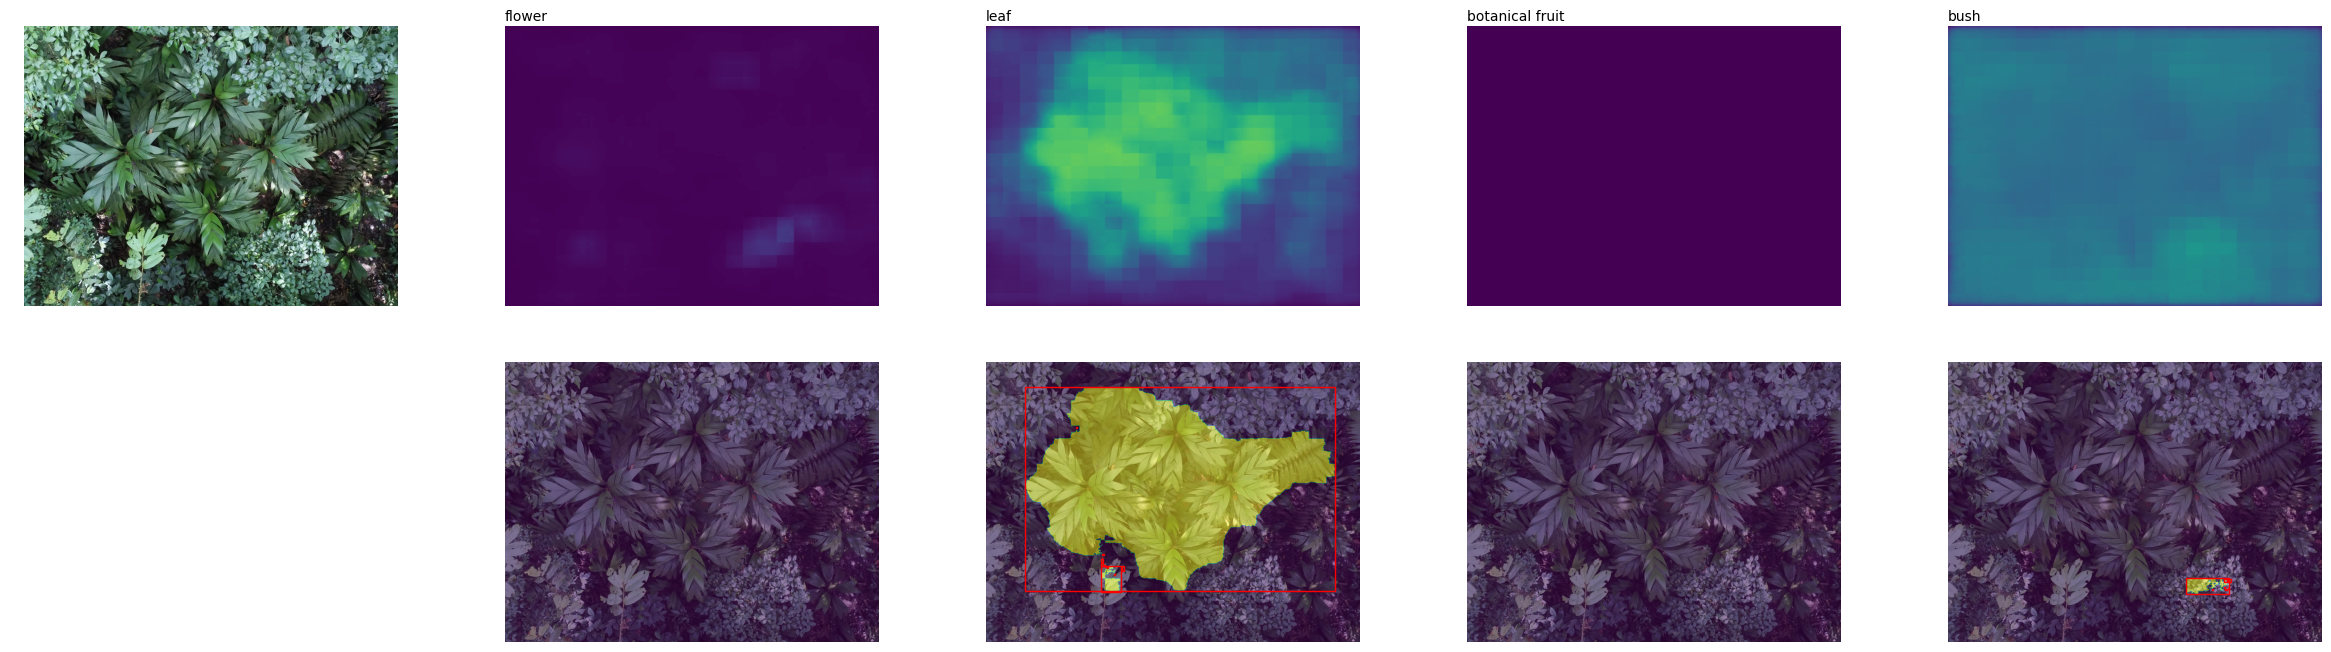

In [123]:
directory_path = R"G:\.shortcut-targets-by-id\1BCCfXZq98f4rFOF8m0AweybL4qQakAUB\Summer Dive 2022\Monteverde Imagery - Stephanie\River\Dry Flight\100MEDIA"
# image_basename = "P1480443.JPG"  # two red fruits
# image_basename = "P2120507.JPG"  # big bush with fruits
image_basename = "P0960390.JPG"  # ferns, no flowers
# image_basename = "P1090403.JPG"  # palm tree with cool fruits, no flowers
# image_basename = "P1580453.JPG"  # log with fungus
# image_basename = "P2330528.JPG"  # flowers on bush, and sky
# image_basename = "P0800374.JPG"  # vine with tiny yellow flowers
# image_basename = "P1280422.JPG"  # bush with colorful leaves
# image_basename = "P1250419.JPG"  # tree trunk, bush w colorful leaves


# directory_path = R"C:\Users\duker\Documents\id_from_image\clip_test_images"
# image_basename = "orange_maple.JPG"


image_path = os.path.join(directory_path, image_basename)

with Image.open(image_path).convert("RGB") as image:
    # resize so not humongous 
    image = image.resize((1024, int(1024 * image.height / image.width)))

    # crop to find smaller flowers
    # crop_box = (0.4, 0.2, 0.6, 0.5) # fractional x0, y0, x1, y1
    # crop_box_scaled = (crop_box[0]*image.width, crop_box[1]*image.height, crop_box[2]*image.width, crop_box[3]*image.height)
    # image = image.crop(crop_box_scaled)

    prompts = ["flower", "leaf", "botanical fruit", "bush"]
    # fungus isn't the most robust prompt (thinks non fungus is fungus often) - mushroom is better - but still iffy

    inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt")
    
    # predict
    with torch.no_grad():
        outputs = model(**inputs)
        preds = outputs.logits.unsqueeze(1)
        
    _, ax = plt.subplots(2, len(prompts) + 1, figsize=(6*(len(prompts) + 1), 8))
    [a.axis('off') for a in ax.flatten()]
    ax[0][0].imshow(image)

    # show results
    for i, prompt in enumerate(prompts):
        sigmoid_logits_square = torch.sigmoid(preds[i][0]).numpy()
        # resize to image size
        sigmoid_logits = cv2.resize(sigmoid_logits_square, (image.width, image.height))

        # show the sigmoid logits
        ax[0][i+1].imshow(sigmoid_logits, vmin=0, vmax=1)
        ax[0][i+1].text(0, -15, prompt)

        print(sigmoid_logits.shape)

        # get bounding boxes - use this method: https://stackoverflow.com/questions/58419893/generating-bounding-boxes-from-heatmap-data
        thresholded = cv2.threshold((255*sigmoid_logits).astype("uint8"), 128, 255, cv2.THRESH_BINARY)[1]
        # thresholded = cv2.threshold((255*sigmoid_logits).astype("uint8"), 128, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
        ax[1][i+1].imshow(image)
        ax[1][i+1].imshow(thresholded, alpha=0.5)
        contours = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = contours[0] if len(contours) == 2 else contours[1]
        for c in contours:
            x,y,w,h = cv2.boundingRect(c)
            ax[1][i+1].add_patch(plt.Rectangle((x, y), w, h, edgecolor='red', facecolor=(0,0,0,0), lw=1))


In [148]:
def find_objects(image, prompts):
    # image is a PIL image

    # resize so not humongous 
    if image.width > 1024:
        image = image.resize((1024, int(1024 * image.height / image.width)))

    # prepare clipseg model inputs
    inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt")
    
    # predict
    with torch.no_grad():
        outputs = model(**inputs)
        preds = outputs.logits.unsqueeze(1)
    
    # prepare figure and show image
    _, ax = plt.subplots(3, len(prompts) + 1, figsize=(6*(len(prompts) + 1), 12))
    [a.axis('off') for a in ax.flatten()]
    ax[0][0].imshow(image)

    # show results
    for i, prompt in enumerate(prompts):
        sigmoid_logits_square = torch.sigmoid(preds[i][0]).numpy()
        # resize to image size
        sigmoid_logits = cv2.resize(sigmoid_logits_square, (image.width, image.height))

        # show the sigmoid logits
        ax[0][i+1].imshow(sigmoid_logits, vmin=0, vmax=1)
        ax[0][i+1].text(0, -15, prompt)

        # blur the sigmoid logits for more reliable thresholding
        blur = cv2.GaussianBlur(sigmoid_logits, (51,51), 0)
        ax[1][i+1].imshow(blur, vmin=0, vmax=1)

        # get bounding boxes - use this method: https://stackoverflow.com/questions/58419893/generating-bounding-boxes-from-heatmap-data
        thresholded = cv2.threshold((255*blur).astype("uint8"), 128, 255, cv2.THRESH_BINARY)[1]
        # thresholded = cv2.threshold((255*sigmoid_logits).astype("uint8"), 128, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
        ax[2][i+1].imshow(image)
        ax[2][i+1].imshow(thresholded, alpha=0.5)
        contours = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = contours[0] if len(contours) == 2 else contours[1]
        for c in contours:
            x,y,w,h = cv2.boundingRect(c)
            ax[2][i+1].add_patch(plt.Rectangle((x, y), w, h, edgecolor='red', facecolor=(0,0,0,0), lw=1))


Unused or unrecognized kwargs: padding.


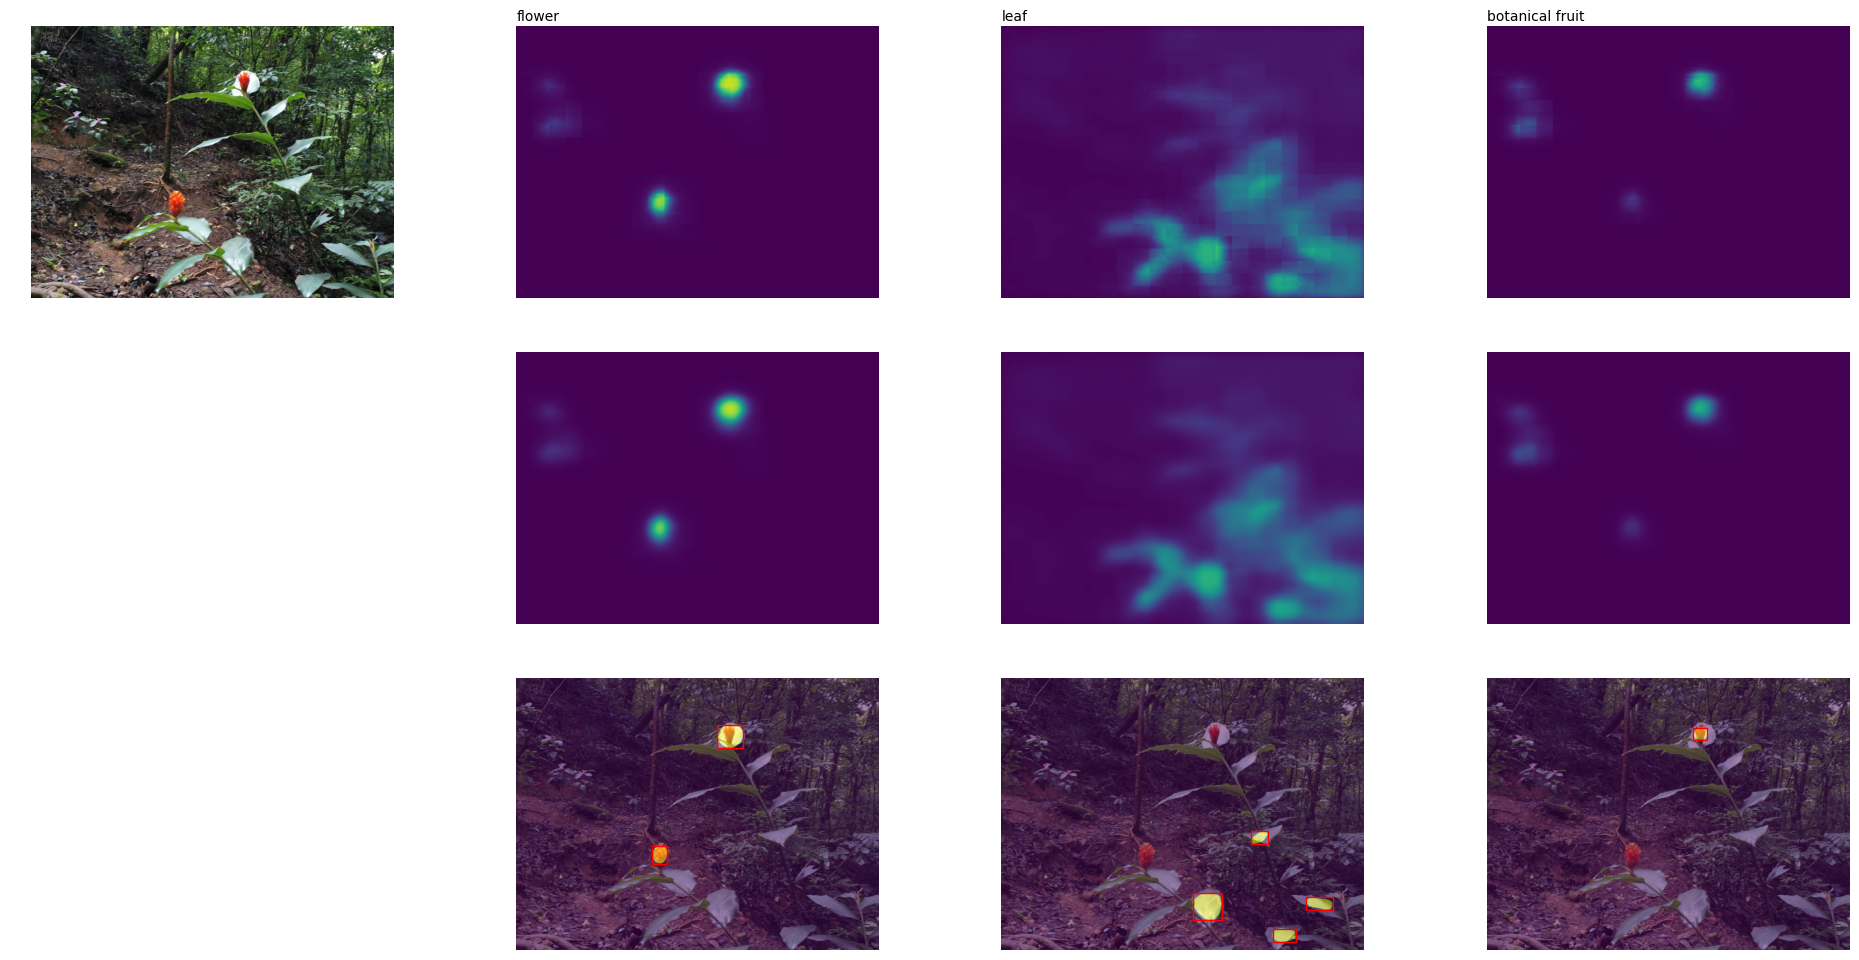

In [149]:
directory_path = R"G:\.shortcut-targets-by-id\1BCCfXZq98f4rFOF8m0AweybL4qQakAUB\Summer Dive 2022\Monteverde Imagery - Stephanie\River\Dry Flight\100MEDIA"
image_basename = "P1480443.JPG"  # two red fruits
# image_basename = "P2120507.JPG"  # big bush with fruits
# image_basename = "P0960390.JPG"  # ferns, no flowers
# image_basename = "P1090403.JPG"  # palm tree with cool fruits, no flowers
# image_basename = "P1580453.JPG"  # log with fungus
# image_basename = "P2330528.JPG"  # flowers on bush, and sky
# image_basename = "P0800374.JPG"  # vine with tiny yellow flowers
# image_basename = "P1280422.JPG"  # bush with colorful leaves
# image_basename = "P1250419.JPG"  # tree trunk, bush w colorful leaves
# image_basename = "P2110506.JPG"  # canopy tree with lots of pale pink fruits


# directory_path = R"C:\Users\duker\Documents\id_from_image\clip_test_images"
# image_basename = "orange_maple.JPG"


image_path = os.path.join(directory_path, image_basename)

with Image.open(image_path).convert("RGB") as image:
    find_objects(image, ["flower", "leaf", "botanical fruit"])